In [ ]:
!unzip cough_det.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [3]:
tf.keras.utils.set_random_seed(1234)

In [4]:
imagePath = "/content/melspectrograms/training"
test_path="/content/melspectrograms/testing"

In [5]:
batch_size=64
img_height = 255
img_width = 255

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePath,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1600 files belonging to 2 classes.
Using 1280 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePath, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1600 files belonging to 2 classes.
Using 320 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.


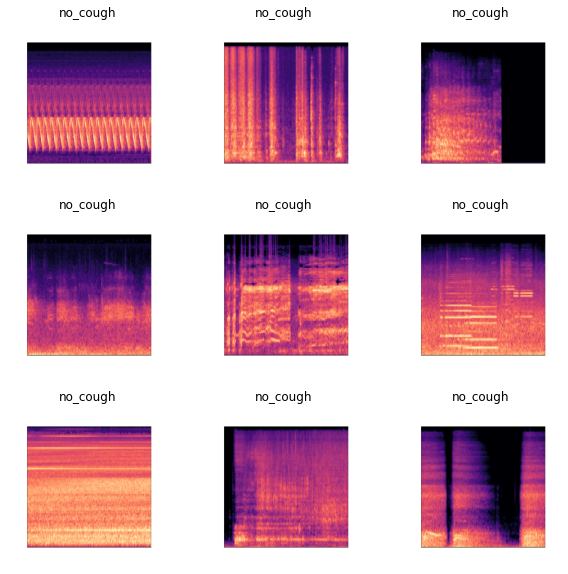

In [9]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
inputs= keras.Input(shape=(255,255,3))
#x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
        
#Block: 1
x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


#Block: 2
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = Flatten(name='flatten')(x)
x = Dense(units=8, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [20]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [21]:
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [22]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
#callbacks = [checkpoint_best_only, tensorboard_callback]

In [25]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

In [26]:
pos = 32
neg = 1568
total = pos+neg

In [27]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [28]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=5, class_weight = class_weight, callbacks=callbacks)

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 2.3435 - accuracy: 0.9805
Epoch 1: val_accuracy improved from -inf to 0.97812, saving model to checkpoints_best_only
20/20 [==============================] - 30s 1s/step - loss: 2.3435 - accuracy: 0.9805 - val_loss: 0.1059 - val_accuracy: 0.9781
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9805
Epoch 2: val_accuracy did not improve from 0.97812
20/20 [==============================] - 28s 1s/step - loss: 0.1866 - accuracy: 0.9805 - val_loss: 0.1926 - val_accuracy: 0.9781
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9805
Epoch 3: val_accuracy did not improve from 0.97812
20/20 [==============================] - 28s 1s/step - loss: 0.1027 - accuracy: 0.9805 - val_loss: 0.0926 - val_accuracy: 0.9781
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9805
Epoch 4: val_accuracy did not improve from 0.978

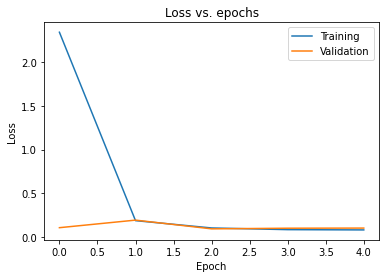

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

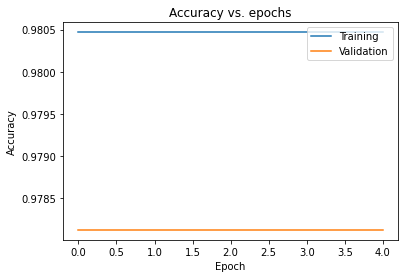

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [31]:
results = model.evaluate(test_ds, verbose=2)

7/7 - 5s - loss: 0.1011 - accuracy: 0.9800 - 5s/epoch - 659ms/step


In [32]:
results

[0.10109616070985794, 0.9800000190734863]

In [33]:
x_test= tf.concat([x for x, y in test_ds], axis=0)
y_test= tf.concat([y for x, y in test_ds], axis=0)

In [34]:
y_pred_keras = model.predict(test_ds)

In [35]:
y_pred=np.array([])
for i in y_pred_keras:
  #print(round(i[0]))
  y_pred=np.append(y_pred, round(i[0]))

In [36]:
y_test_np=y_test.numpy()

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_np, y_pred)

In [38]:
cm

array([[  0,   8],
       [  0, 392]])

In [39]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_np, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [40]:
auc_keras

0.5

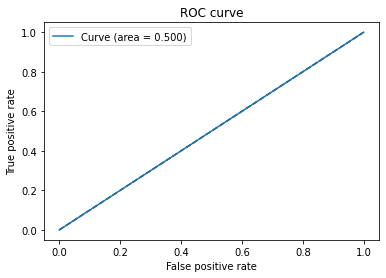

In [41]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Curve (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [42]:
true_positive=cm[1][1]
false_positive=cm[0][1]
false_negative=cm[1][0]
true_negative=cm[0][0]
accuracy=(true_positive+ true_negative)/(true_positive+false_positive+false_negative+true_negative)

In [43]:
accuracy

0.98

In [44]:
precision=true_positive/(true_positive+false_positive)

In [45]:
precision

0.98

In [46]:
recall=true_positive/(true_positive+false_negative)

In [47]:
recall

1.0

In [48]:
f1=2*((precision*recall)/(precision+recall))

In [49]:
f1

0.98989898989899